In [ ]:
using Pkg
Pkg.activate(".")

In [171]:
#Pkg.add(path="https://github.com/ComputationalPsychiatry/ActiveInference.jl.git", rev="new_struct_dev")

In [172]:
include("utils.jl")

Main.SymposiumUtils

In [173]:
using ActiveInference
using Plots
using Distributions

In [174]:
n_states = [3] # 3 Bandits 
n_observations = [2] # Reward or Loss 
n_controls = [3] # 3 Arms to pull 
policy_length = 1 

A,B,C,D = create_matrix_templates(n_states, n_observations, n_controls, policy_length, "uniform");

In [175]:
A[1]

2×3 Matrix{Float64}:
 0.5  0.5  0.5
 0.5  0.5  0.5

In [176]:
# Action 1 
B[1][:,:,1] = [0.82 0.82 0.82; # To arm 1 
               0.10 0.10 0.10; 
               0.08 0.08 0.08]

# Action 2
B[1][:,:,2] = [0.10 0.10 0.10; 
               0.82 0.82 0.82; # To arm 2
               0.08 0.08 0.08]

# Action 3
B[1][:,:,3] = [0.08 0.08 0.08; 
               0.10 0.10 0.10;
               0.82 0.82 0.82] # To arm 3

3×3 Matrix{Float64}:
 0.08  0.08  0.08
 0.1   0.1   0.1
 0.82  0.82  0.82

In [177]:
C[1] = [3.0, -3.0] # Prefers reward (1) over loss (2)

2-element Vector{Float64}:
  3.0
 -3.0

In [178]:
D[1] = [1.0, 0.0, 0.0] # Start at arm 1


3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [179]:
generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]


In [180]:
perceptual_process = DiscretePOMDP.CAVI(
        A_learning = DiscretePOMDP.Learn_A(concentration_parameter=1.0, forgetting_rate=0.8),
);


👁️  Perceptual Process Information

⚙️  Perceptual Process: CAVI

📊 Learning Configuration:
   • A-parameter learning: true
   • B-parameter learning: false
   • D-parameter learning: false


In [181]:
action_process = DiscretePOMDP.ActionProcess(
    policy_length=1,
    use_states_info_gain=true,
    use_param_info_gain=true,
    use_utility=true
);


🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 1
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: true

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


In [182]:
model = AIFModel(
    generative_model = generative_model,
    perceptual_process = perceptual_process,
    action_process = action_process
);

In [183]:
environment = SymposiumUtils.MAB(p=0.9, switch_after=25, seed=42);

In [184]:
observation = [1]
action = [1]

TRIALS = 100

store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

In [185]:
for trial in 1:TRIALS
    # Perform Active Inference  
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

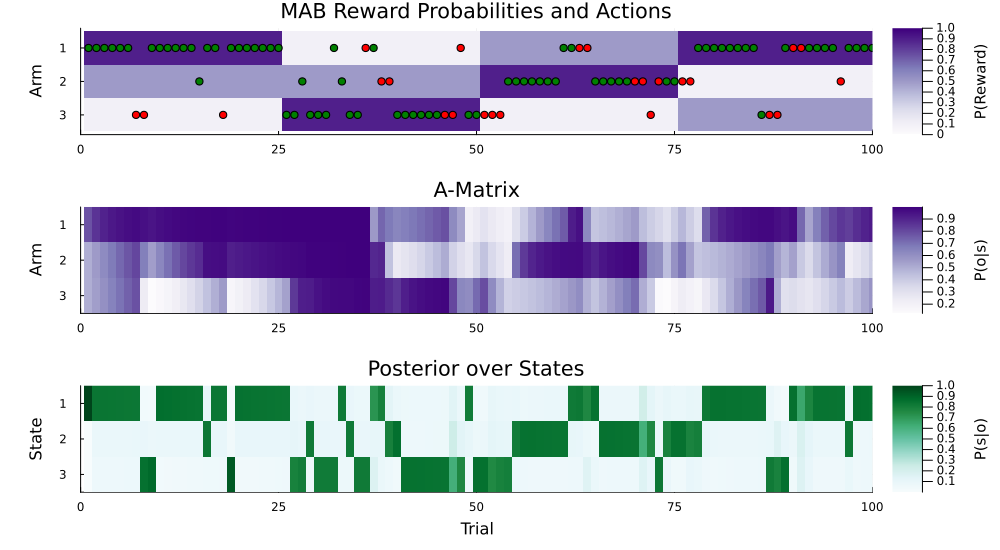

In [186]:
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)


## 2. Creating a Custom Perceptual Process


In [187]:
import ActiveInference.ActiveInferenceCore.AbstractPerceptualProcess
import ActiveInference.DiscretePOMDP.NonFactorized.Learn_A

In [188]:
mutable struct CustomPerceptualProcess <: AbstractPerceptualProcess
    inference_function::Function
    A_learning::Union{Nothing, Learn_A}

    posterior_states::Union{Vector{Vector{Float64}}, Nothing}
    previous_posterior_states::Union{Vector{Vector{Float64}}, Nothing}
    prediction_states::Union{Vector{Vector{Float64}}, Nothing}
    observation::Union{Vector{Int}, Nothing}
    predicted_states::Union{Vector{Vector{Vector{Vector{Float64}}}}, Nothing}
    predicted_observations::Union{Vector{Vector{Vector{Vector{Float64}}}}, Nothing}
    B_learning::Nothing
    D_learning::Nothing

    function CustomPerceptualProcess(; 
        inference_function::Function=nothing, 
        A_learning=nothing
    )
        new(
            inference_function,    # inference_function
            A_learning,            # A_learning
            nothing,               # posterior_states
            nothing,               # previous_posterior_states
            nothing,               # prediction_states
            nothing,               # observation
            nothing,               # predicted_states
            nothing,               # predicted_observations
            nothing,               # B_learning
            nothing                # D_learning
        )
    end
end

In [191]:
using LogExpFunctions: softmax

In [192]:
function analytical_perception(model::AIFModel, prior, observation)
    A_n = deepcopy(model.generative_model.A)

    obs_idx = findfirst(x -> x == 1.0, observation[1])

    log_likelihood = log.(A_n[1][obs_idx,:] .+ 1e-16)
    log_prior = log.(prior[1] .+ 1e-16)

    qs = [softmax(log_likelihood .+ log_prior, dims=1)]

    return qs
end

analytical_perception (generic function with 1 method)

In [203]:
model = AIFModel(
    generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true), 

    perceptual_process = CustomPerceptualProcess(
        inference_function = analytical_perception,
        A_learning = Learn_A(concentration_parameter=1.0, forgetting_rate=0.8)),

    action_process = DiscretePOMDP.ActionProcess(
        policy_length=1,
        use_param_info_gain=true)
);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]

🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 1
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: true

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


In [204]:
environment = SymposiumUtils.MAB(p=0.9, switch_after=25, seed=42);

observation = [1]
action = [1]

store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

In [205]:
for trial in 1:TRIALS
    # Perform Active Inference  
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

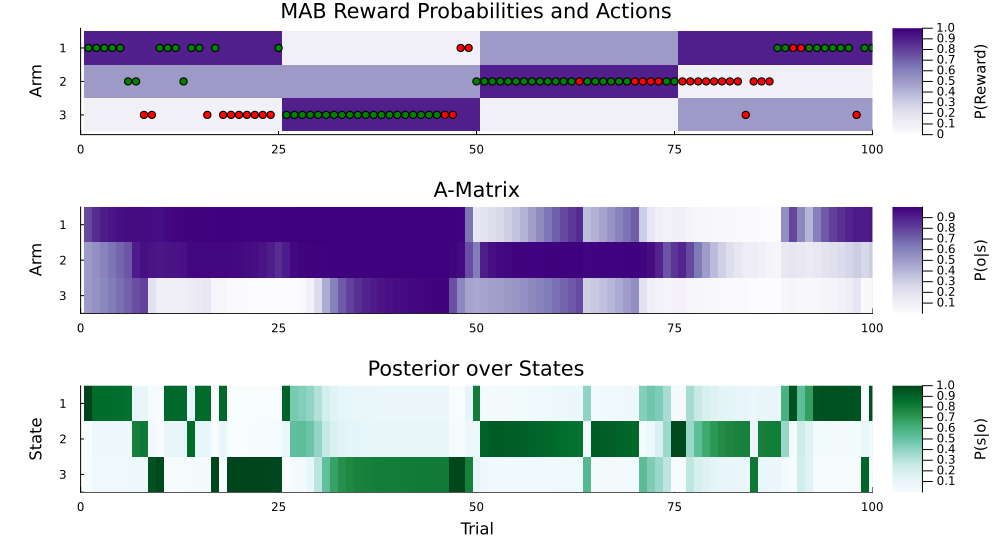

In [207]:
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)


## 3. Using PPLs as parts of the Active Inference model 

In [210]:
using Turing

In [211]:
function turing_perception(model::AIFModel, prior, observation)

    A_n = deepcopy(model.generative_model.A)
    obs_idx = findfirst(x -> x == 1.0, observation[1])

    likelihood = A_n[1]

    turing_model = Turing.@model function _turing_model(prior, likelihood, obs_idx)
        state ~ Categorical(prior[1])                       
        obs_idx ~ Categorical(vec(likelihood[:, state])) 
    end        

    chain = sample(_turing_model(prior, likelihood, obs_idx), MH(), 5000)

    posterior_states = [mean(chain[:state] .== i) for i in 1:3]

    return [posterior_states]
end

turing_perception (generic function with 1 method)

In [212]:
model = AIFModel(
    generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true), 

    perceptual_process = CustomPerceptualProcess(
        inference_function = turing_perception,
        A_learning = Learn_A(concentration_parameter=1.0, forgetting_rate=0.8)),

    action_process = DiscretePOMDP.ActionProcess(
        policy_length=1,
        use_param_info_gain=true)
);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]

🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 1
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: true

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


In [213]:
environment = SymposiumUtils.MAB(p=0.9, switch_after=25, seed=42);

observation = [1]
action = [1]

store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

In [214]:
for trial in 1:TRIALS
    # Perform Active Inference  
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

Sampling   0%|█                                         |  ETA: N/A
Sampling   0%|█                                         |  ETA: 0:06:22
Sampling   1%|█                                         |  ETA: 0:03:12
Sampling   2%|█                                         |  ETA: 0:02:07
Sampling   2%|█                                         |  ETA: 0:01:35
Sampling   2%|██                                        |  ETA: 0:01:16
Sampling   3%|██                                        |  ETA: 0:01:03
Sampling   4%|██                                        |  ETA: 0:00:53
Sampling   4%|██                                        |  ETA: 0:00:46
Sampling   4%|██                                        |  ETA: 0:00:41
Sampling   5%|███                                       |  ETA: 0:00:37
Sampling   6%|███                                       |  ETA: 0:00:33
Sampling   6%|███                                       |  ETA: 0:00:30
Sampling   6%|███                                       |  ETA: 0:00

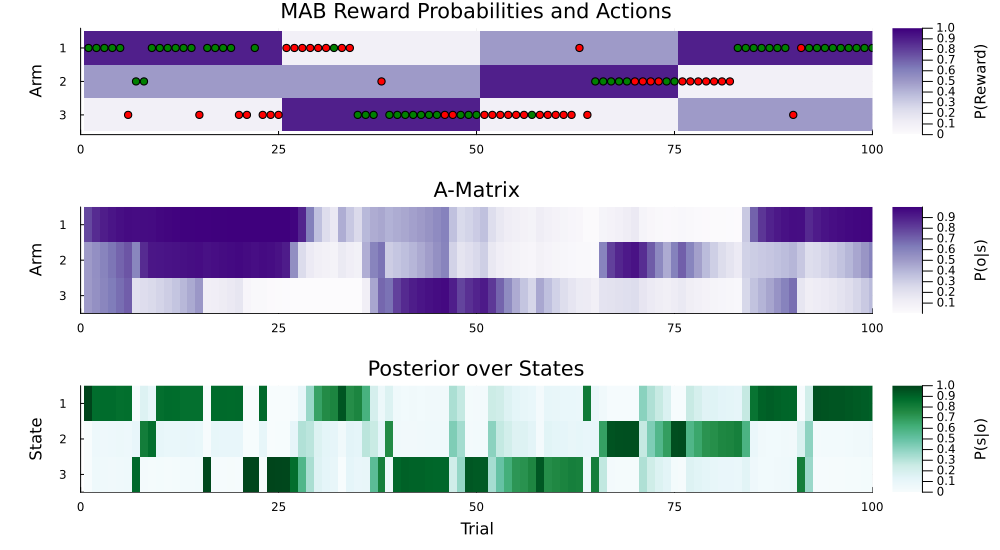

In [215]:
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)
